# Algoritmos de optimización - Trabajo Práctico<br>
Nombre y Apellidos:Unai Begoña Alvarez  <br>
Url: https://github.com/.../03MAIR---Algoritmos-de-Optimizacion---/tree/master/TrabajoPractico<br>
Google Colab: https://colab.research.google.com/drive/xxxxxxxxxxxxxxxx <br>
Problema:

>2. Organizar los horarios de partidos de una jornada de La Liga<br>


Descripción del problema:

....







                                        

Explicacion general del codigo: Por comodidad he hecho el código en un archivo .py y como una clase todo junto. Me ha quedado muy bien pero pasarlo ahora a un notebook no es posible. Por eso para utilizarlo voy a importar el codigo aqui y listo. Pero voy a copiar las funciones aqui para explicarlo

#Modelo
- ¿Como represento el espacio de soluciones?
- ¿Cual es la función objetivo?
- ¿Como implemento las restricciones?

#Represencación del espacion de soluciones: Networkx

En mi caso para representar el espacio de soluciones he decidido utilizar una libreria networkx. Esta libreria tiene como principal objetivo crear grafos para luego calcular la ruta mas optima utilizando el algoritmo dikjstra pero en mi caso  no lo voy a utilizar para eso. En mi caso lo voy a utilizar para modelar el arbor que voy a ir generando con todas las soluciones posibles.


Sé que no es lo mas óptimo a nivel de código utilizar algo tan potente como networkx para generar arboles pero creo que la libreria puede aportarnos funcionalidades muy útiles como la de poder plotear el árbol o incluso obtener de forma fácil y rápida todos los nodos de una única rama. Además, confio en que esta libreria esta muy bien pulida (y sobretodo creada con c++ por dentro) que hace que sea mucho más rápido utilizar sus funciones que crear las mias para iterar entre mis listas o diccionarios.

In [20]:
#Funciones utilizadas gracias a networkx

def draw_graph(self):
        # Dibujar el grafo
        # Usar una disposición jerárquica para el grafo

        plt.figure(figsize=(12, 8)) 
        # pos = nx.spring_layout(self.branch_graph)  # Genera una disposición para los nodos
        pos = nx.multipartite_layout(self.branch_graph, subset_key="layer")
        pos = {node: (y, -x) for node, (x, y) in pos.items()}  # Intercambia x e y
        # Dibuja los edges con mayor transparencia y líneas más delgadas
        nx.draw(
            self.branch_graph,
            pos,
            with_labels=False,  # Desactiva las etiquetas iniciales de los nodos
            node_color='skyblue',
            node_size=200,
            font_size=10,
            edge_color='gray',  # Color de los edges
            width=0.5,          # Grosor más delgado para los edges
            alpha=0.2           # Aumenta la transparencia de los edges
        )

       
        node_labels = {
            node: f"{node}\n" + "\n".join(f"{key}: {value}" for key, value in data.items())
            for node, data in self.branch_graph.nodes(data=True) 
        }
        label_offset = 0
        label_positions = {node: (x - label_offset, y - label_offset) for node, (x, y) in pos.items()}
        # Dibujar las etiquetas de los nodos
        nx.draw_networkx_labels(self.branch_graph, pos, labels=node_labels, font_size=5, font_color='brown')

        # Mostrar el grafo
        plt.title("Visualización del Grafo")
        plt.show()


def draw_branch(self, start_node, end_node):
    """
    Dibuja una rama específica del árbol desde el nodo start_node hasta end_node.
    """
    # Obtener la lista de nodos en la rama
    path_nodes = nx.shortest_path(self.branch_graph, source=start_node, target=end_node)
    
    # Crear un subgrafo con los nodos de la rama
    branch_subgraph = self.branch_graph.subgraph(path_nodes)

    # Generar la disposición para los nodos de la rama usando la capa
    pos = nx.multipartite_layout(self.branch_graph, subset_key="layer")
    pos = {node: (y, -x) for node, (x, y) in pos.items() if node in path_nodes}  # Filtrar solo los nodos de la rama

    # Dibujar los edges con mayor transparencia y líneas más delgadas
    plt.figure(figsize=(8, 6))
    nx.draw(
        branch_subgraph,
        pos,
        with_labels=True,
        node_color='lightcoral',
        node_size=300,
        font_size=8,
        edge_color='black',
        width=1,
        alpha=0.6
    )

    # Etiquetas de los nodos con todos los atributos disponibles
    node_labels = {
        node: f"{node}\n" + "\n".join(f"{key}: {value}" for key, value in data.items())
        for node, data in self.branch_graph.nodes(data=True) if node in path_nodes
    }

    # Posiciones de etiquetas con un pequeño desplazamiento
    label_offset = 0.02
    label_positions = {node: (x - label_offset, y - label_offset) for node, (x, y) in pos.items()}

    # Dibujar etiquetas de nodos
    nx.draw_networkx_labels(branch_subgraph, pos, labels=node_labels, font_size=6, font_color='brown')

    plt.title("Visualización de la Rama")
    plt.show()



#Funcion objetivo

Para la funcion objetivo he creado una funcion que por dentro llama a otras tres funciones. 
    -Una que calcula la cantidad de viewers que puede tener un partido según su categoria
    -Otra que ponderiza esos viewers segun el horario y la fecha
    -Y por ultimo una que ponderiza los viewers si en ese horario existe otro partido


In [33]:
#Funcion objetivo

def calculate_ponderacion_total(self, nodeId : int, match: str):
    total_pon = 0
    previous_nodes = nx.shortest_path(self.branch_graph, source=0, target=nodeId)
    self.calculate_match_coincidence(previous_nodes)
    self.calculate_teams_ponderacion(nodeId, match)
    for previous_nodeId in previous_nodes : 
        nodo_data = self.branch_graph.nodes(data=True)[previous_nodeId]
        coinci_pon = nodo_data.get("coinci_pon")
        cat_pon = nodo_data.get("cat_pon")
        date_pon = nodo_data.get("date_pon")
        if not cat_pon or not coinci_pon or not date_pon:
            continue
        total_pon += coinci_pon * cat_pon * date_pon
    self.branch_graph.nodes[nodeId]["total_pon"] = total_pon

def calculate_match_coincidence(self, previous_nodes: list[int]):
    node_coincidence_dict = {}   
    date_list = [self.branch_graph.nodes[n]["date"] + self.branch_graph.nodes[n]["hour"] for n in previous_nodes if "date" in self.branch_graph.nodes[n]] 
    coinci_dict = self.count_frecuency(date_list) 
    for node in previous_nodes:
        node_data = self.branch_graph.nodes[node]
        if node_data.get("date") and node_data.get("date") + node_data.get("hour") in coinci_dict.keys():
            filt = self.df_coincidence_fact["Numero_coincidencia"] = coinci_dict.get(node_data.get("date") + node_data.get("hour"))
            audience_rating = float(self.df_coincidence_fact.loc[filt, "Factor_audiencia"])
            node_coincidence_dict[node] = audience_rating

    nx.set_node_attributes(self.branch_graph, {node_id: {'coinci_pon': audience_rating} for node_id, audience_rating in node_coincidence_dict.items()})

def calculate_teams_ponderacion(self, nodeId : int, match : str) :
        equipo1 , equipo2 = match.split(" - ")
        mask1 = self.df_team_cat["Equipos"] == equipo1
        mask2 = self.df_team_cat["Equipos"] == equipo2
        cat1 = "Categoria " + self.df_team_cat.loc[mask1, "Categorias"].values[0]
        cat2 = "Categoria " + self.df_team_cat.loc[mask2, "Categorias"].values[0]
        ponderacion = float(self.df_cat_fact.at[cat1, cat2])
        if not ponderacion:
            raise Exception("Ha habido un problema obteniendo la ponderacion de algun partido")
        self.branch_graph.nodes[nodeId]['cat_pon'] = ponderacion



#Restricciones
Para las restricciones, lo único que he metido es que no se pueda crear una solucion en una fecha que no tiene ponderación


#Análisis
- ¿Que complejidad tiene el problema?. Orden de complejidad y Contabilizar el espacio de soluciones

El problema tiene una complejidad de 10^10 esto es porque existen 10 horarios distintos y hay 10 partidos que calcular. Por lo que el espacio total de soluciones es 10^10


#Diseño
- ¿Que técnica utilizo? ¿Por qué?

La tecnica que he utilizado es la de ramificacion y poda y he utilizado esta porque me parecia que habria muchas soluciones que se podrian podar simplemente viendo la ponderacion tan baja que tienen.

Al final he tenido que recurrir a una poda bastante agresiva ya que la cantidad de soluciones se me quedaba muy muy grande en las ultimas iteraciones (ultimos partidos). 

La poda al final la he hecho con le criterio de que la rama no tenga una ponderacion peor que la media. Aun asi he incluido un parametro a la clase que puede ajustar la agresividad de la poda. Lo he programado para que automaticamente sea 1, con esa poda no se tarda mucho y se obtiene una solucion muy razonable: 6.9 millones de espectadores en total

#Ejecicion del codigo.

In [5]:
from match_optimizator import MatchOptimizator

0 iteración
1 iteración
Esta es la cantidad de nodos: 10 .Y este es su valor medio: 0.897 Y este su valor maximo: 1.3
2 iteración
Esta es la cantidad de nodos: 60 .Y este es su valor medio: 1.9467500000000002 Y este su valor maximo: 2.6
3 iteración
Esta es la cantidad de nodos: 320 .Y este es su valor medio: 2.450803125 Y este su valor maximo: 2.9995000000000003
4 iteración
Esta es la cantidad de nodos: 1600 .Y este es su valor medio: 3.38842109375 Y este su valor maximo: 4.081
5 iteración
Esta es la cantidad de nodos: 6940 .Y este es su valor medio: 3.8612590778097986 Y este su valor maximo: 4.4335
6 iteración
Esta es la cantidad de nodos: 25860 .Y este es su valor medio: 4.4268899613302395 Y este su valor maximo: 4.986500000000001
7 iteración
Esta es la cantidad de nodos: 25900 .Y este es su valor medio: 5.157255503861005 Y este su valor maximo: 5.575
8 iteración
Esta es la cantidad de nodos: 13240 .Y este es su valor medio: 5.829096559667674 Y este su valor maximo: 6.095000000000001

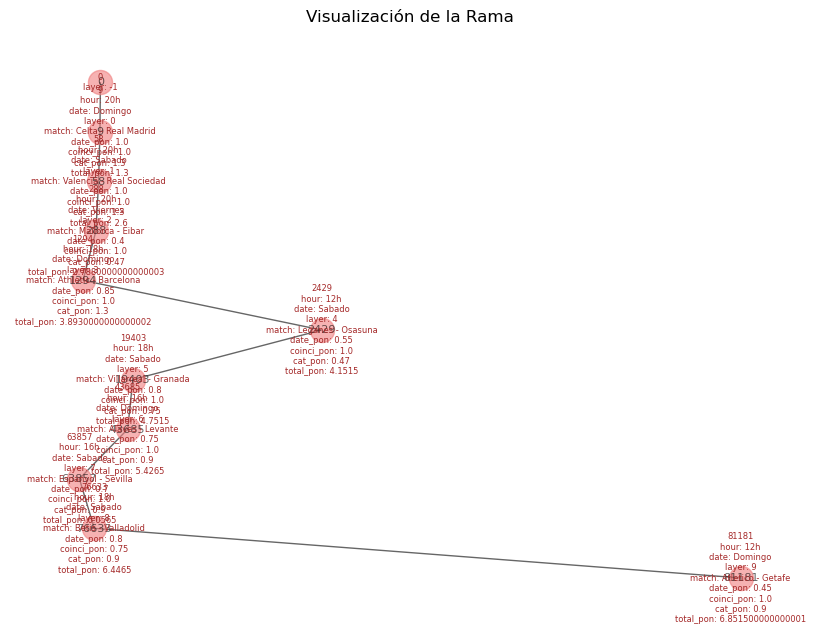

   nodoId                     match hour     date
0       9       Celta - Real Madrid  20h  Domingo
1      58  Valencia - Real Sociedad  20h   Sabado
2     288          Mallorca - Eibar  20h  Viernes
3    1294      Athletic - Barcelona  18h  Domingo
4    2429         Leganes - Osasuna  12h   Sabado
5   19403      Villarreal - Granada  18h   Sabado
6   43685          Alaves - Levante  16h  Domingo
7   63857        Espanyol - Sevilla  16h   Sabado
8   76633        Betis - Valladolid  18h   Sabado
9   81181         Atletico - Getafe  12h  Domingo
 Y este su valor maximo: 6.851500000000001


In [7]:
matchOptimizator = MatchOptimizator()
matchOptimizator.optimizator(pruning_factor=1)

Lo que se puede ver en los siguientes logs es como va aumentando la cantidad de soluciones de manera exponencial pero de una manera menos a la que lo haria si no hubiera poda. Y tambien se ve que cuando la cantidad de nodos es mayor la poda tambien es mayor, esto evita que el algoritmo tarde demasiado.


Cuando acaba la optimizacion selecciono la mejor opcion entre todas las que he calculado y visualizo la rama. En la rama se pueden ver los nodos que indican cada partido, con su horario y sus ponderaciones. Esto me ha venido muy bien para poder debugear el codigo y encontrar errores mientras desarrollaba. 